dy= 0.6931471805599454
a_initial=  0.00643464971052437
Evolving from  2.234253371709851e+19  to  1.0 r_isco  with initial eccentricity 0.999999499999875  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08


/home/pratibhajangra/Desktop/Work/imripy-main/src/imripy/inspiral.py:534: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  t_coal = t_coal * 48./19. / g(e_0)**4 * quad(lambda e: g(e)**4 *(1-e**2)**(5./2.) /e/(1. + 121./304. * e**2), 0., e_0, limit=100)[0]   # The inspiral time according to Maggiore (2007)
/home/pratibhajangra/Desktop/Work/imripy-main/src/imripy/inspiral.py:335: RuntimeWarning: invalid value encountered in sqrt
  v_s = np.sqrt(sp.m_total(a) *(2./r - 1./a))
/home/pratibhajangra/Desktop/Work/imripy-main/src/imripy/halo.py:321: RuntimeWarning: invalid value encountered in double_scalars
  return np.where(r > self.r_min, self.rho_spike * (self.r_spike/r)**self.alpha, 0.)
/home/pratibhajangra/Desktop/Work/imripy-main/src/imripy/inspiral.py:337: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return -(1.-e**2)**(3./2.)/2./np.pi

Required step size is less than spacing between numbers.
 -> Evolution took 3.5515s
here
Evolving from  2.234253371709851e+19  to  1.0 r_isco  with initial eccentricity 0.9999976792028902  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08


/home/pratibhajangra/Desktop/Work/imripy-main/src/imripy/inspiral.py:153: RuntimeWarning: invalid value encountered in double_scalars
  return -32./5. * sp.m_reduced(a)**2 * sp.m_total(a)**3 / a**5  / (1. - e**2)**(7./2.) * (1. + 73./24. * e**2 + 37./96. * e**4)
/home/pratibhajangra/Desktop/Work/imripy-main/src/imripy/inspiral.py:337: RuntimeWarning: invalid value encountered in double_scalars
  return -(1.-e**2)**(3./2.)/2./np.pi * quad(integrand, 0., 2.*np.pi, limit = 100)[0]
/home/pratibhajangra/Desktop/Work/imripy-main/src/imripy/inspiral.py:361: RuntimeWarning: invalid value encountered in double_scalars
  return -(1.-e**2)**(3./2.)/2./np.pi *np.sqrt(sp.m_total(a) * a*(1.-e**2)) *  quad(integrand, 0., 2.*np.pi, limit = 100)[0]


Required step size is less than spacing between numbers.
 -> Evolution took 3.5622s
here
Evolving from  2.234253371709851e+19  to  1.0 r_isco  with initial eccentricity 0.9999892277685294  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
Required step size is less than spacing between numbers.
 -> Evolution took 3.3859s
here
Evolving from  2.234253371709851e+19  to  1.0 r_isco  with initial eccentricity 0.9999499987499375  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
Required step size is less than spacing between numbers.
 -> Evolution took 3.5349s
here
Evolving from  2.234253371709851e+19  to  1.0 r_isco  with initial eccentricity 0.9997678936216339  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-08
Required step size is less than spacing between numbers.
 -> Evolution took 3.1878s
here
Evolving from  2.234253371709851e+19  to  1.0 r_isco  with initial eccentricity 

/home/pratibhajangra/Desktop/Work/imripy-main/src/imripy/merger_system.py:202: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((self.mass(r) + self.m2)/r**3)
/tmp/ipykernel_143939/4166884088.py:168: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbon_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('tm_refvsj_i_ref.pdf', bbon_inches = 'tight')


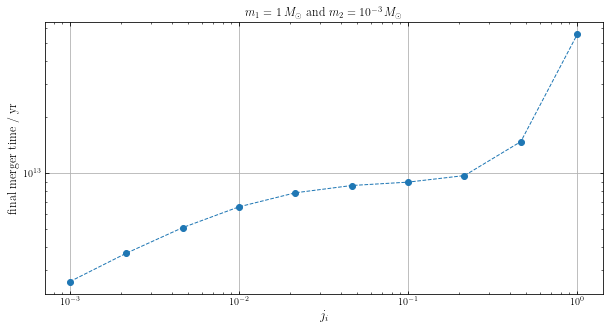

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import imripy
from imripy import merger_system as ms
from scipy.interpolate import interp1d
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
from numpy import diff

plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})



π = np.pi
G = 4.4959e-15            #in units of M☉^-1 pc^3 yr^-2
c = 0.3068                #in units of pc yr^-1
ρ_eq = 3.1812e3           #in units of M☉ pc^-3 with ρ_eq=2.15368e-16 kg m^-3
t_m = 13.78e9             #in units of yrs corresponding to t_0=13.78Gyr
yr = 3.154e7              # in units of seconds
t_eq = 1.59246e12/yr      # in units of yr
M_solar = 1.989e30


# Definition of the binary system 


m_1 = 1e-3   #in units of M☉
m_2 = 2*m_1   #in units of M☉

y_1 = np.log(m_1)
y_2 = np.log(m_2)
dy  = (y_2 - y_1)

print("dy=",dy)

y_list = np.zeros(20)
m_1_list = np.zeros(len(y_list))
m_2_list = np.zeros(len(y_list))

for i in range(len(y_list)):
    m_1_list[i] = m_2_list[i] = (m_1 + ((i/4)*np.exp(dy)))

Δ_1_list = np.zeros(len(y_list))
Δ_2_list = np.zeros(len(y_list))

for i, m_1 in enumerate(m_1_list):
    Δ_1_list[i] =  Δ_2_list[i] = np.exp(m_1 + 0.5*dy) - np.exp(m_1 - 0.5*dy)
     

    

    
def a(m_1,m_2,Δ_1,Δ_2):  # for x = x_bar 
    
    f_pbh = 4.3e-3
    f = 0.85 * f_pbh
        
          
    def P(m): #Powerlaw PBH mass distribution
        α = 1.6
        M = 1e-4     #in units of M☉
        return ((α-1)/M) * ((m/M)**(-α))

    
    def f_(m):
        return f*P(m)
    
    def f_b(m_1,m_2):
        return  f_(m_1)+f_(m_2)
    
    def x̄(m_1,m_2,Δ_1,Δ_2):
        return (((3*(m_1+m_2))/(8*π*ρ_eq*f_b(m_1,m_2)*np.sqrt(Δ_1*Δ_2)))**(1/3))
   
    def λ(m_1,m_2,Δ_1,Δ_2):
        return (8*π*ρ_eq*(x̄(m_1,m_2,Δ_1,Δ_2)**3))/(3*(m_1 + m_2))

    
    return ( 0.0977*λ(m_1,m_2,Δ_1,Δ_2) + 0.0057*(λ(m_1,m_2,Δ_1,Δ_2)**2) ) * x̄(m_1,m_2,Δ_1,Δ_2)





a_initial = a(m_1_list[2], m_2_list[0], Δ_1_list[2], Δ_2_list[0])


print("a_initial= ", a_initial)


# Setting initial and final conditions of the binary evolution for an eccentric orbit
a_i_ref = a_initial * 1e9
j0_array = np.geomspace(1e-3, 1, 10)
j0_ref_list = j0_array.tolist()





plt.figure(figsize = (10, 5))
plt.rc('lines', linewidth=1)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.tick_params(which='both', right=True, top=True)






tm_ref_list = np.zeros(len(j0_ref_list))
T_list = np.zeros(len(j0_ref_list))


for k, j0 in enumerate (j0_ref_list):
    m_bar = 1
    m1 =  m_bar * ms.solar_mass_to_pc  
    m2 = 1e-3 * ms.solar_mass_to_pc   
    D_luminosity = 5e8              
    ρ_bar = (ρ_eq/2) * (t_eq**(3/2)) * ((2 * G * m_bar)**(3/4))   
    r_spike = 1  # in parsecs, Choosen by choice
    alpha = 9/4
    rho_spike =  ρ_bar * (r_spike**(-alpha)) * ms.solar_mass_to_pc  
    spike = imripy.halo.Spike(rho_spike, r_spike, alpha)
    sp = ms.SystemProp(m1, m2, spike, D_luminosity)
    a_fin = sp.r_isco()      # Choosen equal to r_icso
    R_fin = sp.r_isco()      # The final condition for the evolution
    e0 = np.sqrt(1 -(j0**2))
    
    
    m_2_ref = 1 # in units of solar mass
    T = 1e-5 * (t_m * ms.year_to_pc ) * ((m2/m_2_ref)**(-1))
    
    ev_ecc = imripy.inspiral.Classic.Evolve(sp, a_i_ref , e0,  a_fin = R_fin, t_fin = T)
    tm = ev_ecc.t[-1]
    
    print("here")
    while np.isclose(T, tm) == True: 
        T = T * 1000
        ev_ecc = imripy.inspiral.Classic.Evolve(sp, a_i, e0,  a_fin = R_fin, t_fin = T)
        tm = ev_ecc.t[-1]
        
            
            
    tm_ref_list[k] = tm/ms.year_to_pc
    T_list[k] =  T/ms.year_to_pc
      
    
   
   
    
    np.savez("tmofjo",  j0_ref_list,  tm_ref_list)

    
    
plt.loglog(j0_ref_list, tm_ref_list, '--o')


print(tm_ref_list)
    

plt.xlabel('$j_{i}$', fontsize = 13)
plt.ylabel('final merger time / yr', fontsize = 12)
plt.title('$m_{1} = 1 \, M_{\odot}$ and $m_{2}= 10^{-3} \,  M_{\odot}$ ')
plt.grid()
plt.savefig('tm_refvsj_i_ref.pdf', bbon_inches = 'tight')
plt.show()

/home/pratibhajangra/miniconda3/envs/PhD/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


A = 54583249.628572494
B = 1.0


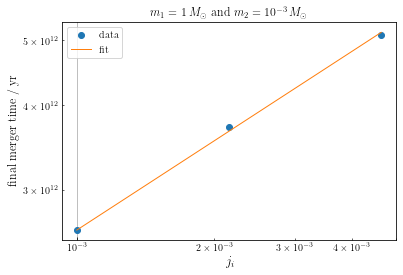

5.458e+13


In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def f(j0, A, B):  
    y =  1e6* (j0**0.44) * A 
    return y


j  = (j0_ref_list[0], j0_ref_list[1], j0_ref_list[2] )
t  = (tm_ref_list[0], tm_ref_list[1], tm_ref_list[2])

j0 = np.array(j)
tm = np.array(t)




parameters, covariance = curve_fit(f, j0, tm)
fit_A = parameters[0]
fit_B = parameters[1]
print("A =", fit_A)
print("B =", fit_B)


fit_y = f(j0, fit_A, fit_B)
plt.loglog(j0, tm, 'o', label='data')
plt.plot(j0, fit_y, '-', label='fit')
plt.xlabel('$j_{i}$', fontsize = 13)
plt.ylabel('final merger time / yr', fontsize = 12)
plt.title('$m_{1} = 1 \, M_{\odot}$ and $m_{2}= 10^{-3} \,  M_{\odot}$ ')
plt.grid()
plt.legend()
plt.savefig('extrapolate.pdf', bbox_inches = 'tight')
plt.show()


print('%0.3e'%(1e6 * fit_A))



# as per the fit t_m = 5.458e+13 * (j0**0.44).

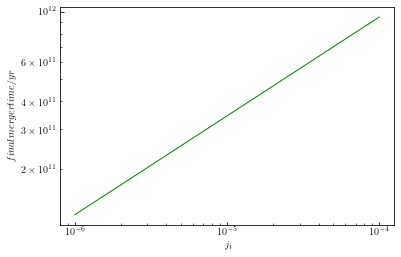

j0_lower_values = [1e-06, 1.6681005372000591e-06, 2.782559402207126e-06, 4.641588833612782e-06, 7.742636826811277e-06, 1.2915496650148827e-05, 2.1544346900318823e-05, 3.5938136638046256e-05, 5.994842503189409e-05, 0.0001]

final merger time / yr = [1.25035556e+11 1.56607050e+11 1.96150350e+11 2.45678338e+11
 3.07712148e+11 3.85409504e+11 4.82725452e+11 6.04613689e+11
 7.57278721e+11 9.48491692e+11]


In [88]:
j0_array_2 = np.geomspace(1e-6, 1e-4, 10)

j0_array_2_list = j0_array_2.tolist()

def t_final_merger(j0):
    return  (5.458e+13 * (j0**0.44))
    
t_final_merger_list = np.zeros(len(j0_array_2))

for i, j0 in enumerate(j0_array_2_list):
    t_final_merger_list[i] = t_final_merger(j0)
    
    
plt.loglog(j0_array_2_list, t_final_merger_list, 'g')
plt.xlabel('$j_{i}$')
plt.ylabel('$final merger time/yr$')
plt.show()


print("j0_lower_values =", j0_array_2_list)
print('\v')
print("final merger time / yr =", t_final_merger_list)

In [91]:
file = np.load('tmofjo.npz')
ji_ref_list = file['arr_0']
tm_ref_list = file['arr_1']


j_initial_list =  j0_array_2_list + j0_ref_list



t_final_list =  np.append(t_final_merger_list, tm_ref_list)




np.savez("tm_ofj_initial",  j_initial_list,  t_final_list)